# Local Environment Reconstruction with Spectra

In this notebook, we will compare the performance of different spectra (power spectrum, bispectrum, trispectrum) with different orders of spherical harmonics for local environment reconstruction.

In [10]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)
import spectra as spectra
from utils.alignment import align_signals, find_best_random_quaternion
from utils.plotters import visualize_geometry

import pickle
import jax
import jax.numpy as jnp
from tqdm import tqdm

We begin by loading in a dataset of the first 10000 local environments of heavy atoms in QM9.

In [11]:
with open('../data/qm9_local_envs_10000.pkl', 'rb') as f:
    local_envs = pickle.load(f)

local_envs = local_envs[:20]
print(f"Number of local environments: {len(local_envs)}")

visualize_geometry(jnp.array(local_envs[0]))

Number of local environments: 20


In [12]:
reconstruction_errors = {(lmax, order): None for lmax in range(1, 5) for order in range(1, 3)}

key = jax.random.PRNGKey(0)

for lmax, order in reconstruction_errors.keys():
    print(f"lmax = {lmax}, order = {order}")

    # Initialize the spectrum
    spectrum = spectra.Spectra(lmax=lmax, order=order)

    total_error = 0
    for local_env in tqdm(local_envs):

        # Convert the local environment to a jax array
        local_env = jnp.array(local_env)
        
        # Compute the signal of the local environment
        local_env_signal = spectra.sum_of_diracs(local_env, lmax)
        
        # Compute the spectrum of the local environment
        local_env_spectrum = spectrum.compute_geometry_spectra(local_env)

        # Invert the spectrum to get the predicted geometry
        predicted_geometry = spectrum.invert(local_env_spectrum)

        # Compute the signal of the predicted geometry
        predicted_signal = spectra.sum_of_diracs(predicted_geometry, lmax)

        # Align the predicted signal with the local environment signal
        initial_quaternion = find_best_random_quaternion(key, predicted_signal, local_env_signal)
        _, error = align_signals(predicted_signal, local_env_signal, initial_quaternion)

        # Add to the total error
        total_error += error

    reconstruction_errors[(lmax, order)] = total_error / len(local_envs)

lmax = 1, order = 1


100%|██████████| 20/20 [01:18<00:00,  3.93s/it]


lmax = 1, order = 2


100%|██████████| 20/20 [01:18<00:00,  3.94s/it]


lmax = 2, order = 1


100%|██████████| 20/20 [01:31<00:00,  4.57s/it]


lmax = 2, order = 2


100%|██████████| 20/20 [01:32<00:00,  4.64s/it]


lmax = 3, order = 1


100%|██████████| 20/20 [01:44<00:00,  5.22s/it]


lmax = 3, order = 2


100%|██████████| 20/20 [01:44<00:00,  5.22s/it]


lmax = 4, order = 1


100%|██████████| 20/20 [01:58<00:00,  5.92s/it]


lmax = 4, order = 2


100%|██████████| 20/20 [02:00<00:00,  6.05s/it]


In [43]:
reconstruction_errors = {
    (2, 1): 0.0029132431373000145,
    (2, 2): 0.00042483260040171444,
    (2, 3): 0.00022195777273736894,
    (3, 1): 0.007003693375736475,
    (3, 2): 0.006002460140734911,
    (3, 3): 0.005286031402647495,
    (4, 1): 0.012525515630841255,
    (4, 2): 0.007798651233315468,
    (4, 3): 0.009301247075200081,
}

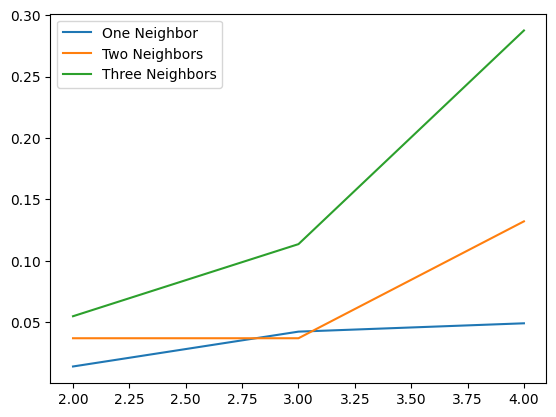

In [45]:
from utils.alignment import loss_fn
import matplotlib.pyplot as plt

one_neighbor = jnp.array([
    [1, 0, 0]
])

one_neighbor_rot = jnp.array([
    [-1, 0, 0]
])

two_neighbors = jnp.array([
    [1, 0, 0],
    [-1, 0, 0]
])

two_neighbors_rot = jnp.array([
    [0, 1, 0],
    [0, -1, 0]
])

three_neighbors = jnp.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

three_neighbors_rot = jnp.array([
    [-1, 0, 0],
    [0, -1, 0],
    [0, 0, -1]
])


one_neighbor_losses = {}
two_neighbors_losses = {}
three_neighbors_losses = {}
identity_quaternion = jnp.array([1, 0, 0, 0])

for lmax in range(2, 5):
    signal_one_neighbor = spectra.sum_of_diracs(one_neighbor, lmax)
    signal_one_neighbor_rot = spectra.sum_of_diracs(one_neighbor_rot, lmax)
    one_neighbor_losses[lmax] = loss_fn(identity_quaternion, signal_one_neighbor, signal_one_neighbor_rot)

    signal_two_neighbors = spectra.sum_of_diracs(two_neighbors, lmax)
    signal_two_neighbors_rot = spectra.sum_of_diracs(two_neighbors_rot, lmax)
    two_neighbors_losses[lmax] = loss_fn(identity_quaternion, signal_two_neighbors, signal_two_neighbors_rot)

    signal_three_neighbors = spectra.sum_of_diracs(three_neighbors, lmax)
    signal_three_neighbors_rot = spectra.sum_of_diracs(three_neighbors_rot, lmax)
    three_neighbors_losses[lmax] = loss_fn(identity_quaternion, signal_three_neighbors, signal_three_neighbors_rot)

plt.plot(list(one_neighbor_losses.keys()), list(one_neighbor_losses.values()), label="One Neighbor")
plt.plot(list(two_neighbors_losses.keys()), list(two_neighbors_losses.values()), label="Two Neighbors") 
plt.plot(list(three_neighbors_losses.keys()), list(three_neighbors_losses.values()), label="Three Neighbors")
plt.legend()
plt.show()

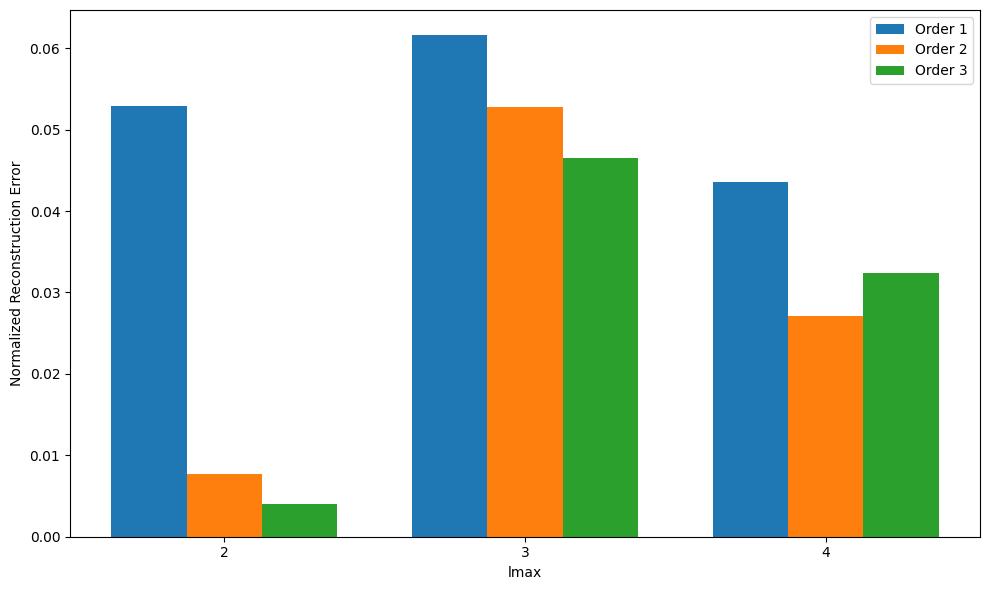

In [46]:
# Plot normalized reconstruction errors for each lmax and order
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.25

lmax_range = range(2, 5)
orders = [1, 2, 3]

for i, order in enumerate(orders):
    errors = []
    for lmax in lmax_range:
        error = reconstruction_errors.get((lmax, order), 0)
        errors.append(error / three_neighbors_losses[lmax])
        
    offset = width * (i - 1)
    ax.bar([x + offset for x in range(len(lmax_range))], errors, width, 
           label=f'Order {order}')

ax.set_ylabel('Normalized Reconstruction Error')
ax.set_xlabel('lmax')
ax.set_xticks(range(len(lmax_range)))
ax.set_xticklabels(lmax_range)
ax.legend()

plt.tight_layout()
plt.show()


In [48]:
signal_one_neighbor = spectra.sum_of_diracs(one_neighbor, 4)
sig_array = signal_one_neighbor.array

In [51]:
import e3nn_jax as e3nn

new_signal = e3nn.IrrepsArray(signal_one_neighbor.irreps, sig_array)

In [56]:
signal_one_neighbor.irreps

1x0e+1x1o+1x2e+1x3o+1x4e